In [1]:
%pylab inline
from IPython.display import display, Math, Latex
maths = lambda s: display(Math(s))
latex = lambda s: display(Latex(s))

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Coin(object):
    """
    A simple coin class, that we can toss to get heads or tails, 
    it could be represented by a binary random variable x,
    where x=1 (heads) or x=0 (tails)

    Can have a biased coin, by changing mu, the probability x=1 (heads)
    """
    def __init__(self, mu=0.5):
        self.mu = mu
        
    def toss(self, n=1):
        return int_(random_sample(size=n) < self.mu)
    
    def pmf(self, x):
        # p(x=0|mu) = (1-mu)
        # p(x=1|mu) = mu
        # ie, the Bernoulli distribution
        # which can be written as:
        return self.mu**x * (1-self.mu)**(1-x)

    

In [3]:
# Now we can toss a coin
Coin().toss()

array([1])

In [4]:
# Now we can toss a coin 5 times
Coin().toss(5)

array([0, 1, 1, 0, 1])

Fair Coin   --  Heads: 490 Tails: 510
Biased Coin --  Heads: 593 Tails: 407


Text(0.5, 0, 'Biased Coin')

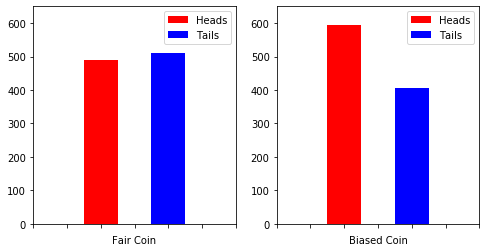

In [5]:
# Toss a fair coin and a biased coin 1000 times
faircoin = Coin(.5)
biasedcoin = Coin(.6)

nsamples = 1000

ftosses = faircoin.toss(nsamples)
btosses = biasedcoin.toss(nsamples)

bheads = sum(btosses == 1)
btails = sum(btosses == 0)

fheads = sum(ftosses == 1)
ftails = sum(ftosses == 0)

print("Fair Coin   -- ", "Heads:", fheads, "Tails:", ftails)
print("Biased Coin -- ", "Heads:", bheads, "Tails:", btails)

figure(figsize=(8,4))
subplot(1,2,1)
b = bar([0,1],[fheads,ftails], color=['r','b'], width=.5)
b[0].set_label("Heads")
b[1].set_label("Tails")
gca().axes.xaxis.set_ticklabels([])
legend()
xlim(-1,2); ylim(0,650)
xlabel("Fair Coin")

subplot(1,2,2)
b = bar([0,1],[bheads,btails], color=['r','b'], width=.5)
b[0].set_label("Heads")
b[1].set_label("Tails")
gca().axes.xaxis.set_ticklabels([])
legend()
xlim(-1,2); ylim(0,650)
xlabel("Biased Coin")


Consider $p(x_n|\mu) = \mu^{x_n}(1-\mu)^{1-x_n}$ for each sample $x_n$ in our dataset D

In [6]:
# Show first 50
print(biasedcoin.pmf(btosses)[:50])

[0.6 0.4 0.6 0.6 0.4 0.4 0.4 0.6 0.6 0.4 0.4 0.6 0.4 0.6 0.4 0.4 0.6 0.4
 0.6 0.4 0.6 0.6 0.4 0.6 0.6 0.4 0.6 0.6 0.6 0.6 0.6 0.4 0.6 0.4 0.4 0.6
 0.4 0.6 0.4 0.6 0.6 0.6 0.6 0.4 0.6 0.6 0.6 0.6 0.6 0.6]


We can find the *likelihood* of all these independent samples by multiplying

$p(D|\mu) = \prod_{n=1}^{N} p(x_n|\mu)$

And taking the log to give the log likelihood, which is nicer numerically:

$\log(p(D|\mu)) = \sum_{n=1}^{N} \log(p(x_n|\mu))$

In [7]:
# Add likelihood and loglikelihood to our coin class
Coin.likelihood = lambda self, data: product(self.pmf(data))
Coin.loglikelihood = lambda self, data: sum(log(self.pmf(data)))

In [8]:
print(biasedcoin.likelihood(btosses))
print(biasedcoin.loglikelihood(btosses))

3.0346453801326247e-294
-675.8499227660134


Now, in order to estimate $\mu$ from our samples we want to maximise the log likelihood -- or minimise the negative log likelihood. 

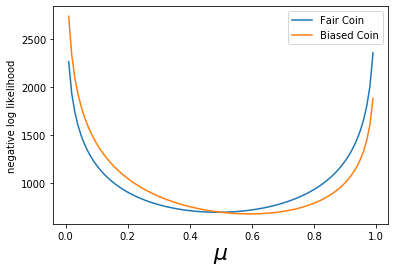

In [9]:
mus = arange(0.01,1,0.01)
ll = zeros(mus.shape)

for i,m in enumerate(mus):
    # "create" a coin for each mu and see how likely the tosses would be
    ll[i] = -Coin(m).loglikelihood(ftosses)
plot(mus, ll, label="Fair Coin")

for i,m in enumerate(mus):
    ll[i] = -Coin(m).loglikelihood(btosses)
plot(mus, ll, label="Biased Coin")
    
xlabel("$\mu$", size=22)
ylabel("negative log likelihood")
legend()

From the graph it looks like the minimum $\mu$ is close to the true one of the coin. And differentiating shows the maximum likelihood estimator is

$\mu_{ML} = \frac{1}{N} \sum_{n=1}^{N}x_n$

i.e. the sample mean (which you probably knew already)

In [10]:
muf = sum(ftosses)/float(nsamples)
mub = sum(btosses)/float(nsamples)

latex("Fair Coin: $\mu_{ML} = %s$" % muf)
latex("Biased Coin: $\mu_{ML} = %s$" % mub)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Now what if we want to estimate the *number* of heads? Call it $k$.

For example, if we toss our biased coin 5 times, the probability of getting 3 heads *then* 2 tails is:

$p(x_1=1)p(x_2=1)p(x_3=1)p(x_4=0)p(x_5=0) = 0.6 \times 0.6 \times 0.6 \times 0.4 \times 0.4$

or $\mu^k(1-\mu)^{N-k}$

But this is just one way to get 3 heads, there are many other sequences of 5 trials that would give us 3 heads. How many exactly? This is given by the [Binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient):

In [11]:
@vectorize
def C(N,k):
    return math.factorial(N)//(math.factorial(N-k)*math.factorial(k))

In [12]:
Ntoss = 5
for k in range(Ntoss+1):
    c =  C(Ntoss,k)
    s = lambda n: "s" if (n-1) else ""
    print("There", "are" if (c-1) else "is", c, "way" + s(c), "of getting", k, "head" + s(k))

There is 1 way of getting 0 heads
There are 5 ways of getting 1 head
There are 10 ways of getting 2 heads
There are 10 ways of getting 3 heads
There are 5 ways of getting 4 heads
There is 1 way of getting 5 heads


This leads us to the Binomial distribution

$Bin(k|N,\mu) = C(N,k)\times\mu^k(1-\mu)^{N-k}$

With mean $N\mu$

We can sample a Binomial distribution by tossing a coin N times and seeing how many heads we get. And if we repeat this step many times we can draw a histogram of how many times we get each number of heads.

Text(0.5, 0, 'k (number of heads)')

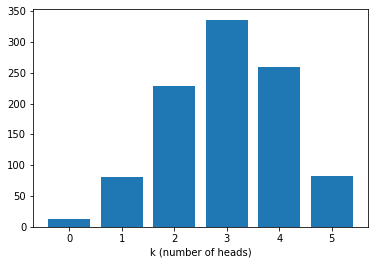

In [13]:
results = []

N_binom = 5
mu_binom = 0.6
Ntrials = 1000

for x in range(Ntrials):
    nheads = sum(Coin(mu_binom).toss(N_binom))
    results.append(nheads)
      
hist(results, bins=range(N_binom+2), rwidth=.8, align='left')

xlabel("k (number of heads)")

Compare with the actual distribution:

Text(0.5, 0, 'k')

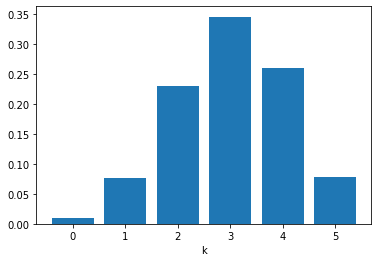

In [14]:
ks = arange(0,N_binom+1,1)

def binomialpmf(k,N,mu):
    return C(N, k) * mu**k * (1-mu)**(N-k)

bar(ks, binomialpmf(ks, N_binom, mu_binom), align='center')
xlabel("k")